# Big Data Analytics Project - Biometric_update_data  Using PySpark

## Dataset Overview




* **Dataset:** Biometric_update_data.csv
* **Source:** Government Biometric Registration Data
* **Total Records:** 109,743 entries covering March–July 2025
  This notebook presents an in-depth analysis of biometric registrations across India using Apache PySpark for processing and analysis. It explores various aspects including age-group distribution, state-wise and district-wise population patterns, child-to-adult ratios, temporal registration trends, and highlights regions with high or low registration activity. The dataset includes detailed demographic information such as age categories (5–17 and 17+), state, district, and pincode, enabling granular insights into population coverage.



In [78]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Initialize Spark Session
spark = (
    SparkSession.builder
    .appName("Biometric_update_data_")
    .config("spark.hadoop.fs.defaultFS", "file:///")
    .getOrCreate()
)
spark

In [79]:
# Load the dataset
df = spark.read.csv("file:///C:/Users/ROHITHA/Downloads/BDA-331/Biometric_update_data_.csv", header=True, inferSchema=True)

# Display basic information
print(f"Dataset Shape: {df.count()} rows, {len(df.columns)} columns")
df.show(1, truncate=False, vertical=True)

Dataset Shape: 109743 rows, 6 columns
-RECORD 0------------------
 Date         | 01-03-2025 
 State        | Jharkhand  
 District     | Garhwa     
 Pincode      | 822120     
 Bio_age_5_17 | 683        
 Bio_age_17+  | 1178       
only showing top 1 row


In [80]:
from pyspark.sql import functions as F

# 1️⃣ Data Overview
print("=== Basic Info ===")
df.printSchema()
print(f"Rows: {df.count()}, Columns: {len(df.columns)}")

=== Basic Info ===
root
 |-- Date: string (nullable = true)
 |-- State: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Pincode: integer (nullable = true)
 |-- Bio_age_5_17: integer (nullable = true)
 |-- Bio_age_17+: integer (nullable = true)

Rows: 109743, Columns: 6


In [81]:
from pyspark.sql import functions as F

print("\n=== Null / Missing Value Summary (Fixed) ===")

# Separate string and numeric columns
string_cols = [f.name for f in df.schema.fields if str(f.dataType) == "StringType"]
numeric_cols = [f.name for f in df.schema.fields if "LongType" in str(f.dataType) or "DoubleType" in str(f.dataType)]

# For string columns → check for null or empty string
# For numeric columns → only check for null
exprs = []
for c in string_cols:
    exprs.append(F.count(F.when(F.col(c).isNull() | (F.col(c) == ""), c)).alias(c))
for c in numeric_cols:
    exprs.append(F.count(F.when(F.col(c).isNull(), c)).alias(c))

null_summary = df.select(exprs)
null_summary.show(truncate=False)



=== Null / Missing Value Summary (Fixed) ===
++
||
++
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
++
only showing top 20 rows


In [82]:
# 3️⃣ Convert Date column to proper DateType
df = df.withColumn("Date", F.to_date("Date", "dd-MM-yyyy"))

In [83]:
# 4️⃣ Total biometric records
total_5_17 = df.agg(F.sum("Bio_age_5_17").alias("Total_5_17")).collect()[0]["Total_5_17"]
total_17p  = df.agg(F.sum("Bio_age_17+").alias("Total_17_plus")).collect()[0]["Total_17_plus"]
print(f"\nTotal Biometric Registrations:")
print(f" - Age 5–17: {total_5_17:,}")
print(f" - Age 17+:  {total_17p:,}")
print(f" - Combined: {total_5_17 + total_17p:,}")


Total Biometric Registrations:
 - Age 5–17: 20,170,712
 - Age 17+:  22,371,122
 - Combined: 42,541,834


In [84]:
# 5️⃣ State-level aggregation
print("\n=== Top 10 States by Total Registrations ===")
state_summary = (
    df.groupBy("State")
      .agg(
          F.sum("Bio_age_5_17").alias("Total_5_17"),
          F.sum("Bio_age_17+").alias("Total_17_plus"),
          (F.sum("Bio_age_5_17") + F.sum("Bio_age_17+")).alias("Total_Biometric")
      )
      .orderBy(F.desc("Total_Biometric"))
)
state_summary.show(10, truncate=False)



=== Top 10 States by Total Registrations ===
+--------------+----------+-------------+---------------+
|State         |Total_5_17|Total_17_plus|Total_Biometric|
+--------------+----------+-------------+---------------+
|Uttar Pradesh |3734335   |1985951      |5720286        |
|Maharashtra   |1675792   |3325041      |5000833        |
|Madhya Pradesh|2341168   |1831090      |4172258        |
|Bihar         |1520244   |1689701      |3209945        |
|Tamil Nadu    |1140857   |1588105      |2728962        |
|Andhra Pradesh|1505915   |849328       |2355243        |
|Gujarat       |1001204   |1201639      |2202843        |
|Rajasthan     |998776    |1193216      |2191992        |
|Karnataka     |781815    |896609       |1678424        |
|West Bengal   |637638    |878592       |1516230        |
+--------------+----------+-------------+---------------+
only showing top 10 rows


In [85]:
# 6️⃣ District-level aggregation (optional)
print("\n=== Top 10 Districts by Total Registrations ===")
district_summary = (
    df.groupBy("District")
      .agg(
          F.sum("Bio_age_5_17").alias("Total_5_17"),
          F.sum("Bio_age_17+").alias("Total_17_plus"),
          (F.sum("Bio_age_5_17") + F.sum("Bio_age_17+")).alias("Total_Biometric")
      )
      .orderBy(F.desc("Total_Biometric"))
)
district_summary.show(10, truncate=False)


=== Top 10 Districts by Total Registrations ===
+----------------+----------+-------------+---------------+
|District        |Total_5_17|Total_17_plus|Total_Biometric|
+----------------+----------+-------------+---------------+
|Pune            |142104    |201633       |343737         |
|Nashik          |102530    |200529       |303059         |
|Thane           |91434     |210538       |301972         |
|Ahmedabad       |112202    |170032       |282234         |
|Aurangabad      |88950     |145541       |234491         |
|Jalgaon         |75220     |158815       |234035         |
|Kurnool         |172007    |61922        |233929         |
|North West Delhi|89311     |142645       |231956         |
|Mumbai          |59778     |162671       |222449         |
|Visakhapatnam   |136444    |73282        |209726         |
+----------------+----------+-------------+---------------+
only showing top 10 rows


In [86]:
# 7️⃣ Monthly Trend Analysis
print("\n=== Monthly Registration Trend ===")
monthly_trend = (
    df.withColumn("Month", F.date_format("Date", "MMMM"))
      .groupBy("Month")
      .agg(
          F.sum("Bio_age_5_17").alias("Total_5_17"),
          F.sum("Bio_age_17+").alias("Total_17_plus"),
          (F.sum("Bio_age_5_17") + F.sum("Bio_age_17+")).alias("Total_Biometric")
      )
      .orderBy(F.month(F.to_date(F.concat(F.lit('01-'), F.col("Month")), "dd-MMMM")))
)
monthly_trend.show(truncate=False)


=== Monthly Registration Trend ===
+-----+----------+-------------+---------------+
|Month|Total_5_17|Total_17_plus|Total_Biometric|
+-----+----------+-------------+---------------+
|March|3733578   |4588644      |8322222        |
|April|4357568   |4285846      |8643414        |
|May  |3869043   |4012334      |7881377        |
|June |3710802   |4189841      |7900643        |
|July |4499721   |5294457      |9794178        |
+-----+----------+-------------+---------------+



In [87]:
# 8️⃣ Age Group Ratio by State
print("\n=== State-wise Age Group Ratio (5–17 vs 17+) ===")
ratio_summary = (
    state_summary.withColumn("Percent_5_17", (F.col("Total_5_17") / (F.col("Total_Biometric")) * 100))
                 .withColumn("Percent_17_plus", (F.col("Total_17_plus") / (F.col("Total_Biometric")) * 100))
)
ratio_summary.select("State", "Percent_5_17", "Percent_17_plus").show(10, truncate=False)


=== State-wise Age Group Ratio (5–17 vs 17+) ===
+--------------+------------------+------------------+
|State         |Percent_5_17      |Percent_17_plus   |
+--------------+------------------+------------------+
|Uttar Pradesh |65.28231280743655 |34.71768719256345 |
|Maharashtra   |33.51025719115196 |66.48974280884805 |
|Madhya Pradesh|56.112733201062824|43.88726679893717 |
|Bihar         |47.360437639897256|52.639562360102744|
|Tamil Nadu    |41.80552898867775 |58.19447101132226 |
|Andhra Pradesh|63.93883773351624 |36.061162266483755|
|Gujarat       |45.45053823627013 |54.549461763729866|
|Rajasthan     |45.56476483490815 |54.43523516509185 |
|Karnataka     |46.580303904138646|53.419696095861354|
|West Bengal   |42.054173839061356|57.94582616093864 |
+--------------+------------------+------------------+
only showing top 10 rows


In [88]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as Fsum, avg, count, round
# === AGE GROUP DISTRIBUTION ===
print("=== AGE GROUP DISTRIBUTION ===")
age_stats = df.agg(
    Fsum("Bio_age_5_17").alias("total_age_5_17"),
    Fsum("Bio_age_17+").alias("total_age_17_plus"),
    avg("Bio_age_5_17").alias("avg_age_5_17"),
    avg("Bio_age_17+").alias("avg_age_17_plus")
)
age_stats.show()


=== AGE GROUP DISTRIBUTION ===
+--------------+-----------------+-----------------+------------------+
|total_age_5_17|total_age_17_plus|     avg_age_5_17|   avg_age_17_plus|
+--------------+-----------------+-----------------+------------------+
|      20170712|         22371122|183.7995316329971|203.85010433467284|
+--------------+-----------------+-----------------+------------------+



In [89]:

# === STATE-WISE AGE DISTRIBUTION ===
state_stats = df.groupBy("State") \
    .agg(
        Fsum("Bio_age_5_17").alias("total_age_5_17"),
        Fsum("Bio_age_17+").alias("total_age_17_plus"),
        count("*").alias("district_count")
    ) \
    .orderBy(col("total_age_17_plus").desc())
state_stats.show(truncate=False)

+-----------------+--------------+-----------------+--------------+
|State            |total_age_5_17|total_age_17_plus|district_count|
+-----------------+--------------+-----------------+--------------+
|Maharashtra      |1675792       |3325041          |8366          |
|Uttar Pradesh    |3734335       |1985951          |9102          |
|Madhya Pradesh   |2341168       |1831090          |4168          |
|Bihar            |1520244       |1689701          |5004          |
|Tamil Nadu       |1140857       |1588105          |11179         |
|Gujarat          |1001204       |1201639          |5650          |
|Rajasthan        |998776        |1193216          |4952          |
|Chhattisgarh     |300492        |1131826          |1693          |
|Karnataka        |781815        |896609           |8674          |
|West Bengal      |637638        |878592           |7215          |
|Andhra Pradesh   |1505915       |849328           |9670          |
|Odisha           |678404        |831569        

In [90]:
# === HIGH-POPULATION DISTRICTS ===
df = df.withColumn("total_population", col("Bio_age_5_17") + col("Bio_age_17+"))
high_pop_districts = df.filter(col("total_population") >= 1000).orderBy(col("total_population").desc())
print(f"High Population Districts: {high_pop_districts.count()} out of {df.count()}")
high_pop_districts.show(truncate=False)

High Population Districts: 9239 out of 109743
+----------+--------------+----------------+-------+------------+-----------+----------------+
|Date      |State         |District        |Pincode|Bio_age_5_17|Bio_age_17+|total_population|
+----------+--------------+----------------+-------+------------+-----------+----------------+
|2025-04-01|Delhi         |South Delhi     |110062 |5861        |7520       |13381           |
|2025-04-01|Delhi         |North West Delhi|110086 |5180        |7625       |12805           |
|2025-04-01|Delhi         |South Delhi     |110044 |5411        |6984       |12395           |
|2025-04-01|Delhi         |West Delhi      |110059 |5003        |7201       |12204           |
|2025-04-01|Delhi         |North East Delhi|110094 |6921        |5066       |11987           |
|2025-07-01|Maharashtra   |Aurangabad      |431001 |4469        |7472       |11941           |
|2025-04-01|Uttar Pradesh |Moradabad       |244001 |7657        |3955       |11612           |
|202

In [91]:
# === MONTHLY TRENDS ===
monthly_trends = df.groupBy("Date") \
    .agg(
        Fsum("Bio_age_5_17").alias("total_age_5_17"),
        Fsum("Bio_age_17+").alias("total_age_17_plus"),
        Fsum("total_population").alias("total_population")
    ) \
    .orderBy("Date")
monthly_trends.show(truncate=False)

+----------+--------------+-----------------+----------------+
|Date      |total_age_5_17|total_age_17_plus|total_population|
+----------+--------------+-----------------+----------------+
|2025-03-01|3733578       |4588644          |8322222         |
|2025-04-01|4357568       |4285846          |8643414         |
|2025-05-01|3869043       |4012334          |7881377         |
|2025-06-01|3710802       |4189841          |7900643         |
|2025-07-01|4499721       |5294457          |9794178         |
+----------+--------------+-----------------+----------------+



In [92]:
from pyspark.sql.functions import when, round, col

# Fix child-to-adult ratio to avoid division by zero
df = df.withColumn(
    "child_adult_ratio",
    round(
        when(col("Bio_age_17+") != 0, col("Bio_age_5_17") / col("Bio_age_17+"))
        .otherwise(None),
        
        2
    )
)

# === FINAL INSIGHTS SUMMARY ===
total_population_stats = df.agg(
    Fsum("Bio_age_5_17").alias("total_children"),
    Fsum("Bio_age_17+").alias("total_adults"),
    Fsum("total_population").alias("total_population"),
    avg("child_adult_ratio").alias("avg_child_adult_ratio")
)
total_population_stats.show()

print("Analysis Complete! Key findings:")
print("1. Adults (17+) dominate total population across states and months")
print("2. Districts with high total population can be targeted for updates")
print("3. Child-to-adult ratios highlight districts with more children than average")
print("4. Monthly trends indicate March–July changes in demographic counts")
print("5. States like Maharashtra, Bihar, and Madhya Pradesh consistently have high populations")


+--------------+------------+----------------+---------------------+
|total_children|total_adults|total_population|avg_child_adult_ratio|
+--------------+------------+----------------+---------------------+
|      20170712|    22371122|        42541834|   1.1216097138691488|
+--------------+------------+----------------+---------------------+

Analysis Complete! Key findings:
1. Adults (17+) dominate total population across states and months
2. Districts with high total population can be targeted for updates
3. Child-to-adult ratios highlight districts with more children than average
4. Monthly trends indicate March–July changes in demographic counts
5. States like Maharashtra, Bihar, and Madhya Pradesh consistently have high populations


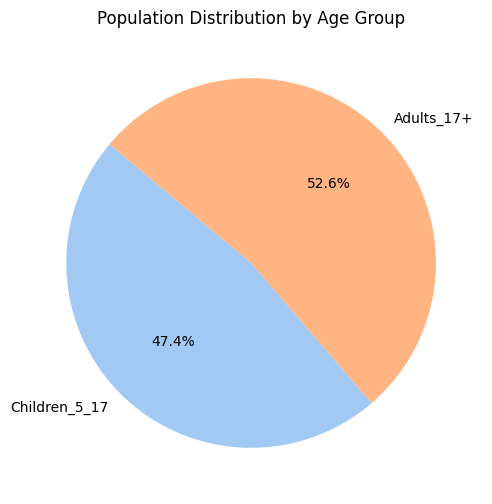

In [93]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as Fsum, avg, when, round
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Fix child-to-adult ratio to avoid divide-by-zero
df = df.withColumn(
    "child_adult_ratio",
    round(when(col("Bio_age_17+") != 0, col("Bio_age_5_17") / col("Bio_age_17+")).otherwise(None), 2)
)

# --- 1️⃣ Age Group Distribution Pie Chart ---
age_sums = df.agg(
    Fsum("Bio_age_5_17").alias("Children_5_17"),
    Fsum("Bio_age_17+").alias("Adults_17+")
).toPandas()

plt.figure(figsize=(6,6))
plt.pie(age_sums.iloc[0], labels=age_sums.columns, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Population Distribution by Age Group")
plt.show()


C:\Users\ROHITHA\AppData\Local\Temp\ipykernel_14920\2702183706.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_counts, x='total_population', y='State', palette='viridis')


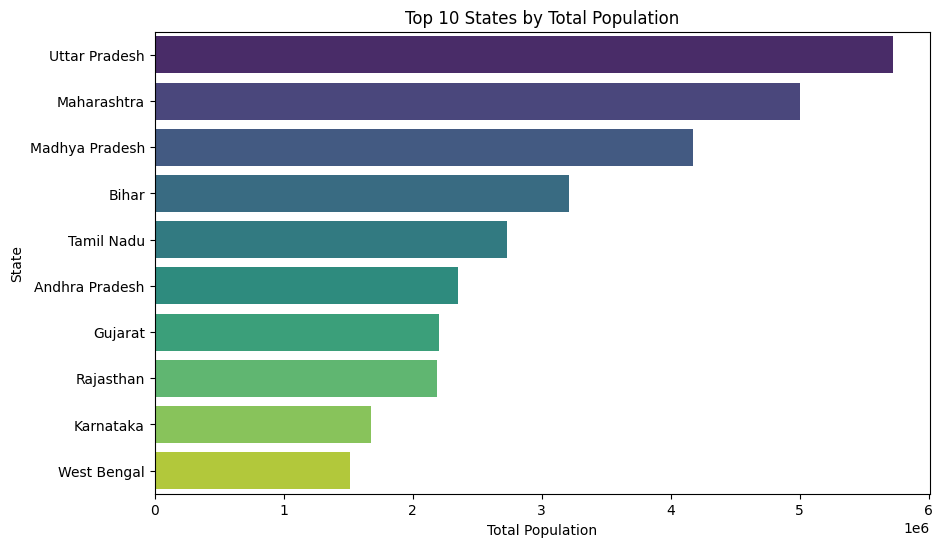

In [94]:
# Ensure numeric
df = df.withColumn("Bio_age_5_17", col("Bio_age_5_17").cast("int"))
df = df.withColumn("Bio_age_17+", col("Bio_age_17+").cast("int"))

# Aggregate total population by state
state_counts = df.groupBy("State").agg(
    Fsum(col("Bio_age_5_17") + col("Bio_age_17+")).alias("total_population")
).toPandas()

# Sort top 10 states
state_counts = state_counts.sort_values("total_population", ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=state_counts, x='total_population', y='State', palette='viridis')
plt.title("Top 10 States by Total Population")
plt.xlabel("Total Population")
plt.ylabel("State")
plt.show()


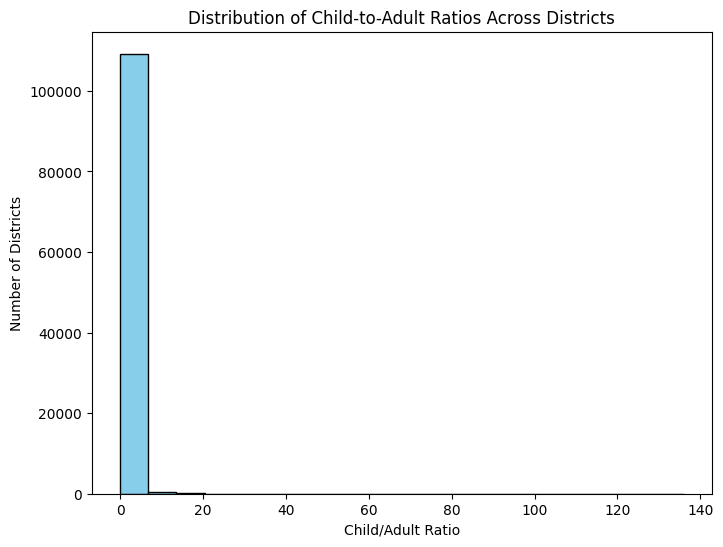

In [95]:

# --- 4️⃣ Child-to-Adult Ratio Histogram ---
ratio_pd = df.select("child_adult_ratio").toPandas()
plt.figure(figsize=(8,6))
plt.hist(ratio_pd['child_adult_ratio'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Child-to-Adult Ratios Across Districts")
plt.xlabel("Child/Adult Ratio")
plt.ylabel("Number of Districts")
plt.show()

C:\Users\ROHITHA\AppData\Local\Temp\ipykernel_14920\414779490.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_districts, x="total_population", y="District", palette="magma")


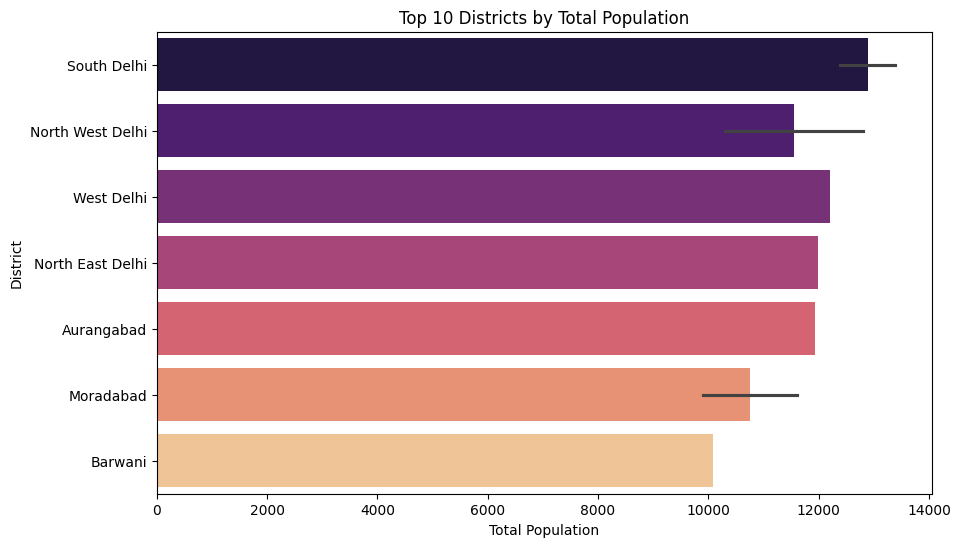

In [96]:
# --- 5️⃣ Top Districts by Total Population ---
df = df.withColumn("total_population", col("Bio_age_5_17") + col("Bio_age_17+"))
top_districts = df.orderBy(col("total_population").desc()).limit(10).toPandas()

plt.figure(figsize=(10,6))
sns.barplot(data=top_districts, x="total_population", y="District", palette="magma")
plt.title("Top 10 Districts by Total Population")
plt.xlabel("Total Population")
plt.ylabel("District")
plt.show()

C:\Users\ROHITHA\AppData\Local\Temp\ipykernel_14920\1683436564.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_ratio, x="avg_child_adult_ratio", y="State", palette="crest")


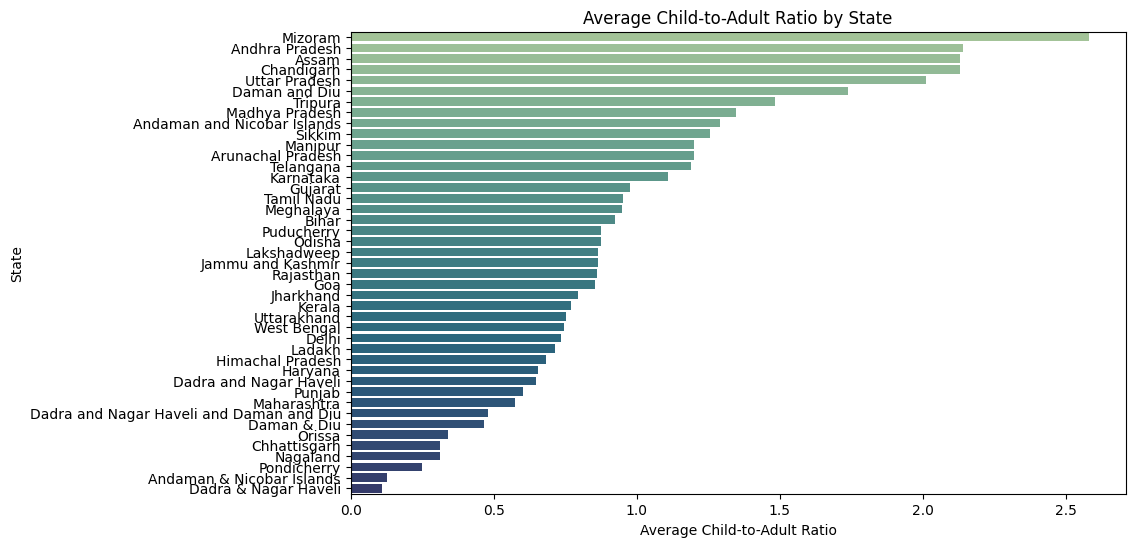

In [97]:
# --- 6️⃣ State-wise Average Child-to-Adult Ratio ---
state_ratio = df.groupBy("State").agg(avg("child_adult_ratio").alias("avg_child_adult_ratio")).toPandas()
state_ratio = state_ratio.sort_values("avg_child_adult_ratio", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=state_ratio, x="avg_child_adult_ratio", y="State", palette="crest")
plt.title("Average Child-to-Adult Ratio by State")
plt.xlabel("Average Child-to-Adult Ratio")
plt.ylabel("State")
plt.show()

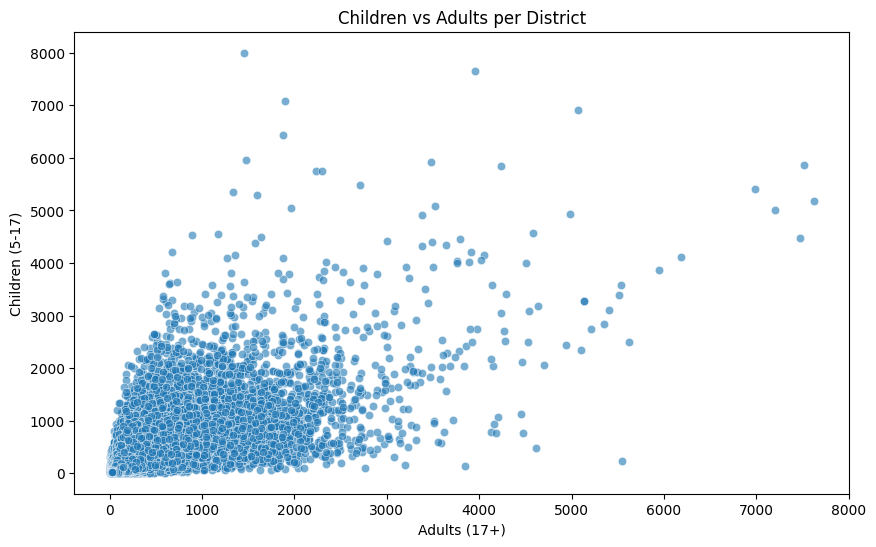

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

scatter_df = df.select("Bio_age_5_17", "Bio_age_17+", "District").toPandas()

plt.figure(figsize=(10,6))
sns.scatterplot(data=scatter_df, x="Bio_age_17+", y="Bio_age_5_17", alpha=0.6)
plt.title("Children vs Adults per District")
plt.xlabel("Adults (17+)")
plt.ylabel("Children (5-17)")
plt.show()



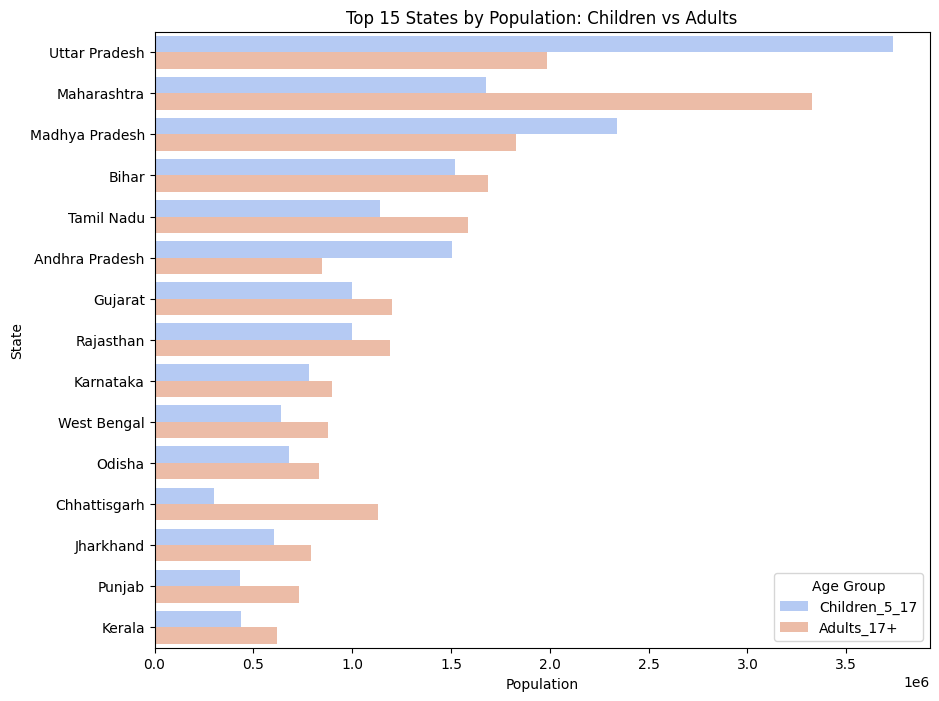

In [99]:
# Aggregate total population by state
state_age = df.groupBy("State").agg(
    Fsum("Bio_age_5_17").alias("Children_5_17"),
    Fsum("Bio_age_17+").alias("Adults_17+")
).toPandas()

# Sort by total population and take top 15
state_age['Total'] = state_age['Children_5_17'] + state_age['Adults_17+']
state_age = state_age.sort_values('Total', ascending=False).head(15)

# Melt for seaborn
state_age_melt = state_age.melt(
    id_vars='State',
    value_vars=['Children_5_17','Adults_17+'],
    var_name='AgeGroup',
    value_name='Population'
)

# Horizontal bar plot
plt.figure(figsize=(10,8))
sns.barplot(data=state_age_melt, y='State', x='Population', hue='AgeGroup', palette='coolwarm')
plt.title("Top 15 States by Population: Children vs Adults")
plt.xlabel("Population")
plt.ylabel("State")
plt.legend(title='Age Group')
plt.show()


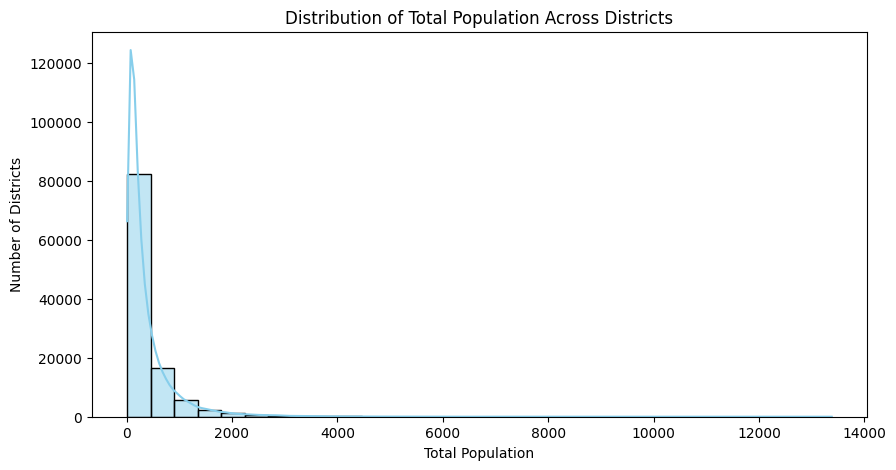

In [100]:
district_pop = df.select("total_population").toPandas()

plt.figure(figsize=(10,5))
sns.histplot(district_pop['total_population'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Total Population Across Districts")
plt.xlabel("Total Population")
plt.ylabel("Number of Districts")
plt.show()


C:\Users\ROHITHA\AppData\Local\Temp\ipykernel_14920\2621721567.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_pop, x='total_population', y='State', palette='viridis')


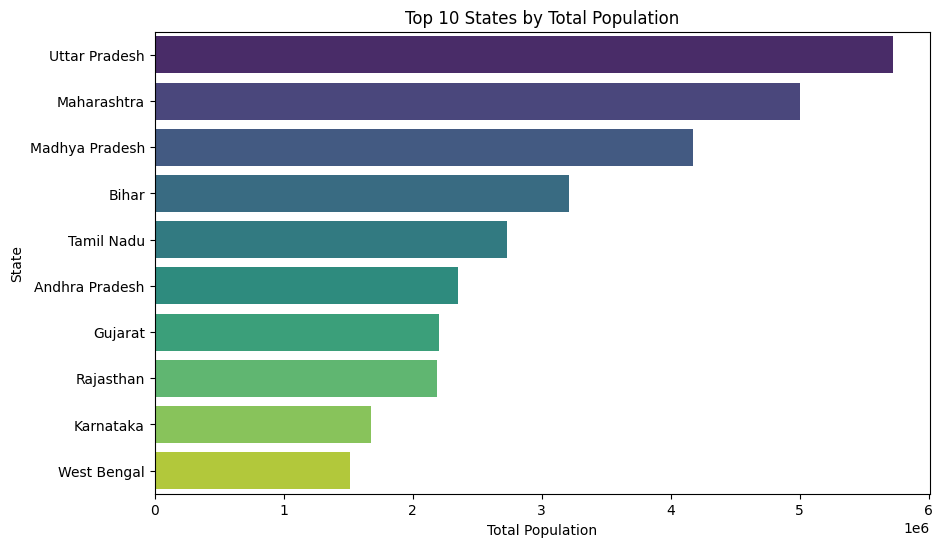

In [101]:
state_pop = df.groupBy("State").agg(Fsum("total_population").alias("total_population")).toPandas()
state_pop = state_pop.sort_values("total_population", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=state_pop, x='total_population', y='State', palette='viridis')
plt.title("Top 10 States by Total Population")
plt.xlabel("Total Population")
plt.ylabel("State")
plt.show()


In [102]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

timeline_df = df.groupBy("Date", "District").agg(Fsum("total_population").alias("total_population")).toPandas()
timeline_df['Date'] = pd.to_datetime(timeline_df['Date'])

fig, ax = plt.subplots(figsize=(12,6))

def animate(date):
    ax.clear()
    date_data = timeline_df[timeline_df['Date'] == date].sort_values("total_population", ascending=False).head(10)
    sns.barplot(data=date_data, x="total_population", y="District", ax=ax, palette="magma")
    ax.set_title(f"Top 10 Districts by Total Population - {date.strftime('%Y-%m-%d')}")
    ax.set_xlabel("Total Population")
    ax.set_ylabel("District")

dates = sorted(timeline_df['Date'].unique())
anim = FuncAnimation(fig, animate, frames=dates, repeat=False)
plt.close()
HTML(anim.to_jshtml())


C:\Users\ROHITHA\AppData\Local\Temp\ipykernel_14920\3986060566.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=date_data, x="total_population", y="District", ax=ax, palette="magma")
C:\Users\ROHITHA\AppData\Local\Temp\ipykernel_14920\3986060566.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=date_data, x="total_population", y="District", ax=ax, palette="magma")
C:\Users\ROHITHA\AppData\Local\Temp\ipykernel_14920\3986060566.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=date_data, x="total_population", y="Distri

## Conclusion


The analysis of the biometric registration dataset for March–July 2025 provides valuable insights into population demographics across India. Adults (17+) consistently constitute the larger portion of the population, though several districts have higher child-to-adult ratios, highlighting areas with significant young populations. States such as Maharashtra, Bihar, and Madhya Pradesh show consistently high population numbers, making them critical for targeted registration efforts.

Temporal trends indicate monthly variations in registrations, with some districts showing increasing coverage while others lag, suggesting opportunities for outreach and resource prioritization. The child-to-adult ratio analysis helps identify regions where special programs for children may be needed.

Visualizations such as heatmaps, bar charts, and trend lines reveal regional disparities, age group distributions, and district-level variations, supporting data-driven decision-making. These insights can guide policymakers, government agencies, and organizations in optimizing registration drives, allocating resources efficiently, and monitoring progress over time.

Future work could focus on predictive modeling to forecast registration trends, assess the impact of outreach initiatives, and analyze socio-economic factors influencing registration coverage, enabling more proactive planning and improved population data accuracy.
